# PV Diagnosis

In case of large-scale renewable energy plants, production output is regularly reviewed to ensure ROI. This is different for small plants. By comparing meteorological data with actual production of a PV power plant, we estimate plant's condition and predict next required maintenance. The analysis detects performance losses and, therby, enhances economic profits. This challenge was part of the Energy Hackdays 2019 (https://hack.opendata.ch/project/284).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Descriptive-Statistics" data-toc-modified-id="Descriptive-Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Descriptive Statistics</a></span><ul class="toc-item"><li><span><a href="#Power-Generation" data-toc-modified-id="Power-Generation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Power Generation</a></span></li><li><span><a href="#Weather-Data" data-toc-modified-id="Weather-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Weather Data</a></span></li><li><span><a href="#Correlation-Analysis" data-toc-modified-id="Correlation-Analysis-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Correlation Analysis</a></span></li></ul></li><li><span><a href="#Descriptive-Analysis" data-toc-modified-id="Descriptive-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Descriptive Analysis</a></span><ul class="toc-item"><li><span><a href="#Scatterplots:-depended-variable-against-independent-variables" data-toc-modified-id="Scatterplots:-depended-variable-against-independent-variables-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scatterplots: depended variable against independent variables</a></span></li></ul></li><li><span><a href="#Time-Series-Analysis" data-toc-modified-id="Time-Series-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Time Series Analysis</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Compare-predctions-with-actual-vales" data-toc-modified-id="Compare-predctions-with-actual-vales-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Compare predctions with actual vales</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Classification</a></span></li></ul></li><li><span><a href="#Further-Research" data-toc-modified-id="Further-Research-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Further Research</a></span></li></ul></div>

## Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sys,os
os.chdir("..")
sys.path.append(os.getcwd())
from preprocessor.paths import (PATH_TO_PLANT_A, PATH_TO_WEATHER)
from preprocessor.preprocessor import Preprocessor

In [2]:
data_plant_a = Preprocessor(path_to_data=PATH_TO_PLANT_A,
                            local_time_column="timestamp",
                           resampling_method="sum").df_indexed_utc

data_weather = Preprocessor(path_to_data=PATH_TO_WEATHER,
                            local_time_column="local_time",
                           resampling_method="mean").df_indexed_utc
df = pd.merge(left=data_plant_a, right=data_weather,
                left_index=True, right_index=True)
df.columns

Index(['generation_kw', 'grid_feedin_kw', 'grid_supply_kw',
       'overall_consumption_calc_kw', 'temperature', 'precipitation',
       'snowfall', 'snow_mass', 'air_density', 'radiation_surface',
       'radiation_toa', 'cloud_cover'],
      dtype='object')

## Descriptive Statistics

### Power Generation

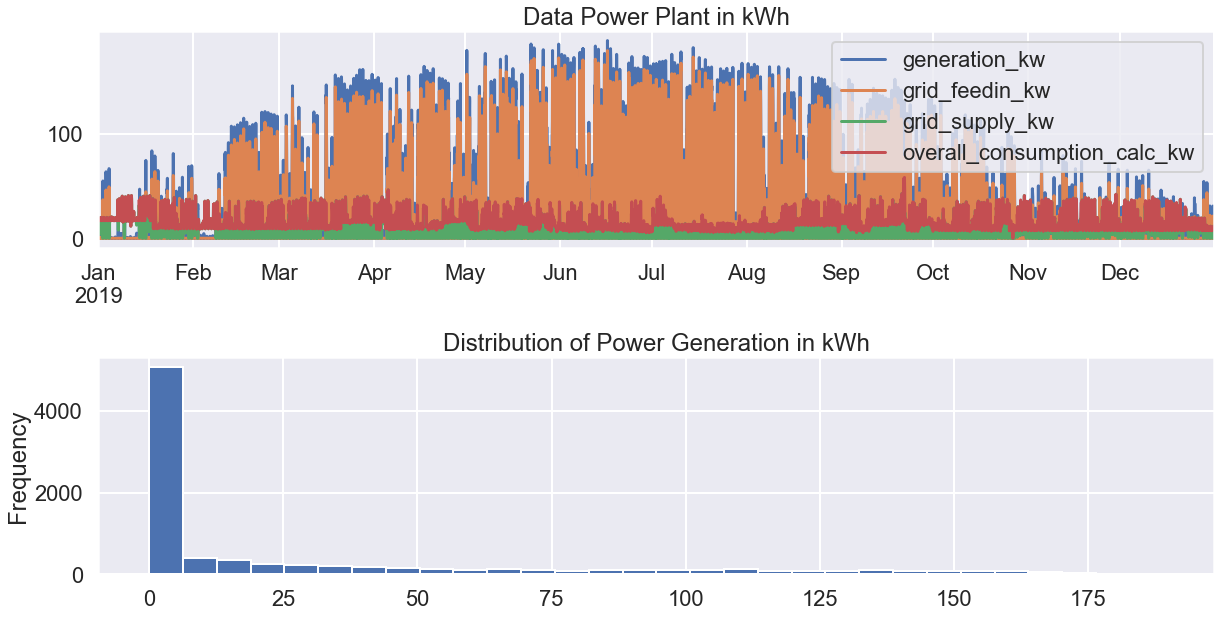

In [3]:
fig, axes = plt.subplots(nrows=2, figsize=(20,10))
plt.subplots_adjust(hspace=0.5)

data_plant_a.plot(ax=axes[0])
axes[0].set_title("Data Power Plant in kWh")
axes[0].set_xlabel("")

data_plant_a["generation_kw"].plot(kind="hist", 
                      bins = 30,
                      ax=axes[1])
axes[1].set_title("Distribution of Power Generation in kWh")

plt.show()

### Weather Data

In [4]:
data_weather.columns

Index(['temperature', 'precipitation', 'snowfall', 'snow_mass', 'air_density',
       'radiation_surface', 'radiation_toa', 'cloud_cover'],
      dtype='object')

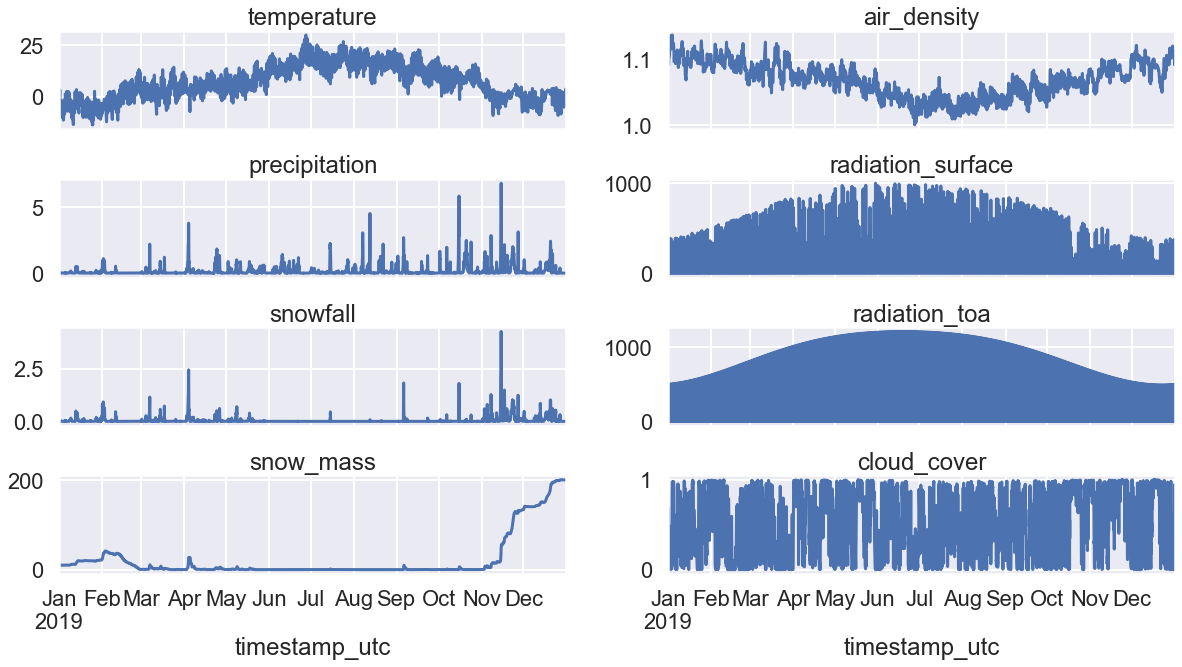

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20,10), sharex=True)
plt.subplots_adjust(hspace=0.5)

variables = ['temperature', 'precipitation', 'snowfall', 'snow_mass', 
             'air_density', 'radiation_surface', 'radiation_toa', 'cloud_cover']
for i in range(len(variables)):
    var = variables[i]
    data_weather[var].plot(ax=axes[i%4][i//4],
                           title=str(var))
plt.show()

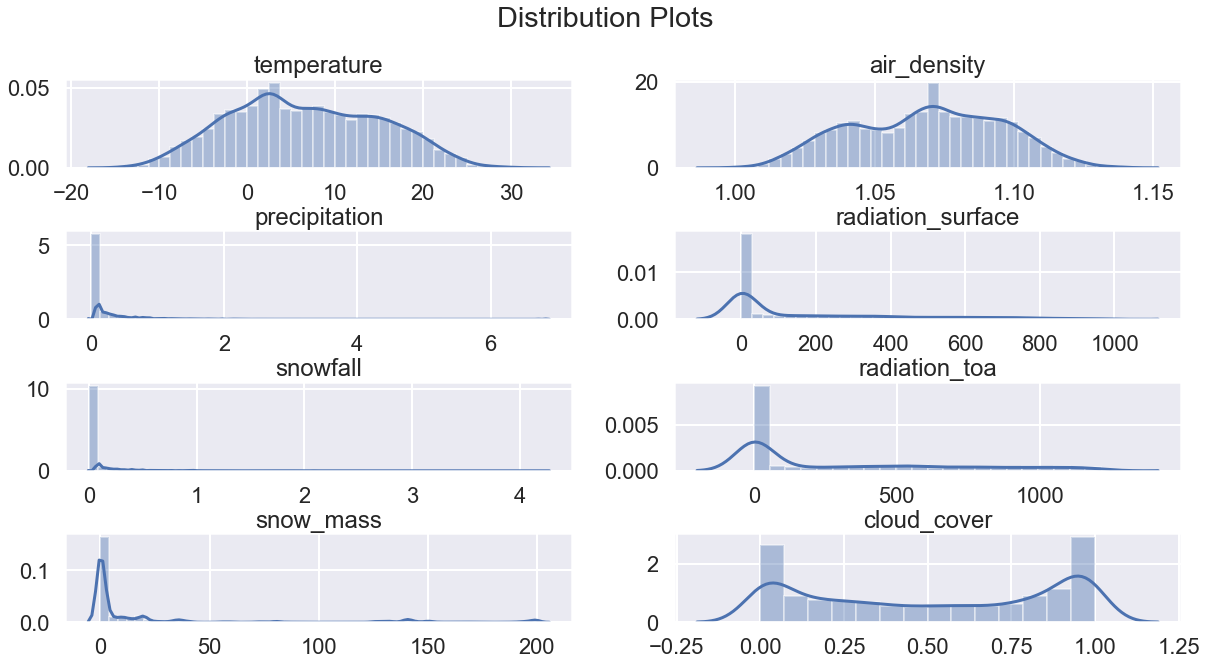

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20,10))
plt.subplots_adjust(hspace=0.7)

for i in range(len(variables)):
    var = variables[i]
    sns.distplot(data_weather[var],
                 ax=axes[i%4][i//4])
    axes[i%4][i//4].set_title(var)
    axes[i%4][i//4].set_xlabel("")
plt.suptitle("Distribution Plots")
plt.show()

### Correlation Analysis

In the following matrix you will see which features correlate with each other.  
A dark green indicates a strong positive correlation and a dark brown a strong negative one.

In [7]:
def corr_heatmap(df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return plt.show()

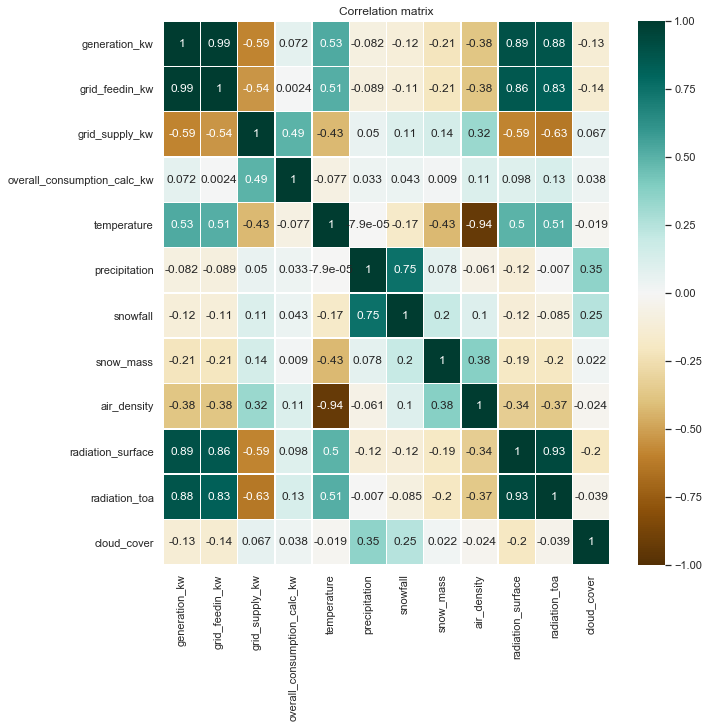

In [8]:
sns.set("notebook")
corr_heatmap(df.corr())

**Findings**
- *generation_kw* is highly correlated with *radiation_surface* and *radiation_toa*, and these are highly correlated with each other --> multicollinearity
- *air_density* and *temperature* are highly negatively correlated --> multicollinearity
- Candidates for predictors: ***radiation_surface*, *precipitation*, *temperature***

## Descriptive Analysis

In [9]:
df["hour"] = df.index.hour
df["month"] = df.index.month

In [10]:
features = ["radiation_surface", "temperature", "hour", "month"]
target = "generation_kw"

X = df[features]
y = df[target]

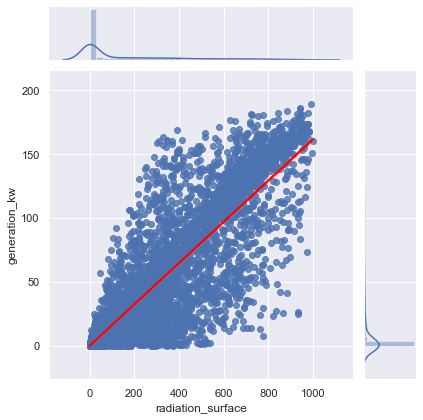

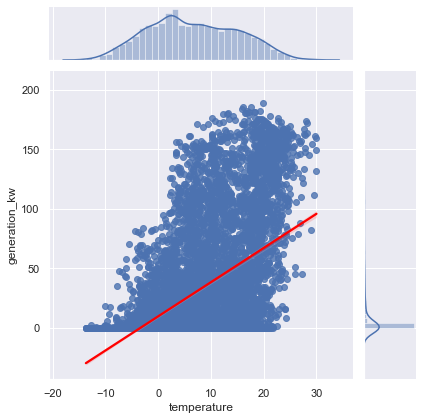

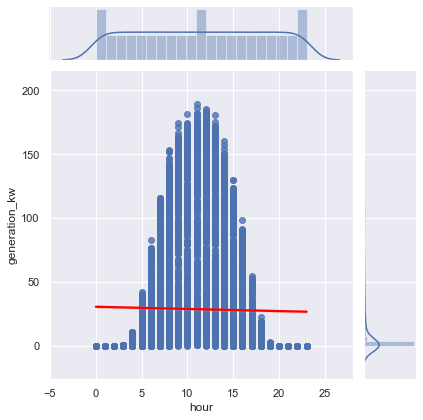

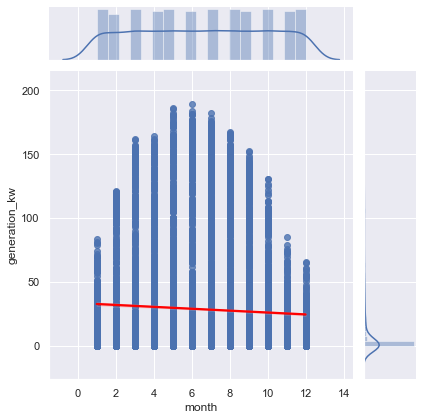

In [11]:
for i in range(len(features)):
    x = features[i]
    g = sns.jointplot(data=df, y=y, x=x, 
                      kind='reg', 
                      joint_kws={'line_kws':{'color':'red'}})
    plt.show()

## Time Series Analysis

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

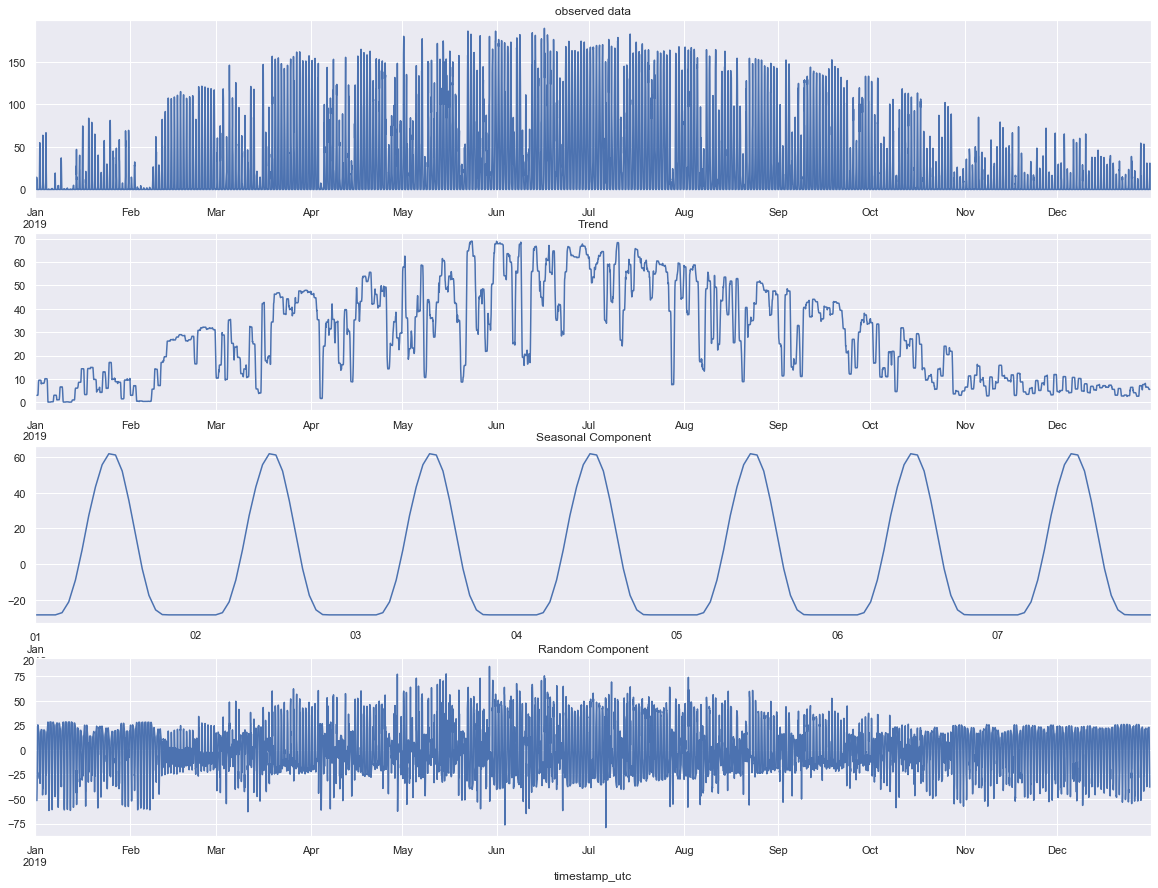

In [13]:
y = df[target].resample("h").mean().ffill()
decomp = seasonal_decompose(y, model='additive')

fig, axes = plt.subplots(nrows=4, figsize=(20,15))
decomp.observed.plot(ax=axes[0], title="observed data")
decomp.trend.plot(ax=axes[1], title="Trend")
decomp.seasonal[0:(24*7)].plot(ax=axes[2], title="Seasonal Component")
decomp.resid.plot(ax=axes[3], title="Random Component")
plt.show()

## Linear Regression

In [14]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]
#regressor_OLS=sm.OLS(endog = y_train, exog = X_train).fit()
#regressor_OLS.summary()

In [115]:
# use features that have no multicollinearity but are relevant considered the correlation matrix
r_formel = "generation_kw ~ radiation_surface * temperature + C(hour) + C(month)"
regressor_OLS=smf.ols(formula=r_formel, data = df_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          generation_kw   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     872.4
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        20:32:56   Log-Likelihood:                -30728.
No. Observations:                7007   AIC:                         6.153e+04
Df Residuals:                    6969   BIC:                         6.179e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -6.2261      1.519     -4.099      0.000      -9.203      -3.249
C(hour)[T.1]                     -0.3342      1.631     -0.205      0.838      -3.531       2.862
C(hour)[T.2]                      0.0228      1.614      0.014      0.989      -3.140       3.186
C(hour)[T.3]                      0.0015      1.639      0.001      0.999      -3.211       3.214
C(hour)[T.4]                     -0.6361      1.625     -0.391      0.695      -3.821       2.549
C(hour)[T.5]                     -0.3250      1.643     -0.198      0.843      -3.547       2.897
C(hour)[T.6]                      0.4153      1.644      0.253      0.800      -2.807       3.637
C(hour)[T.7]                      2.2222      1.736      1.280      0.201      -1.181       5.625
C(hour)[T.8]                      5.4935      1.882      2.919      0.004       1.805       9.182
C(hour)[T.9]                      6.1188      1.983      3.085      0.002       2.231      10.007
C(hour)[T.10]                    10.3047      2.067      4.985      0.000       6.253      14.357
C(hour)[T.11]                    13.1920      2.062      6.398      0.000       9.150      17.234
C(hour)[T.12]                    16.3904      2.036      8.051      0.000      12.399      20.381
C(hour)[T.13]                    16.4509      1.939      8.486      0.000      12.651      20.251
C(hour)[T.14]                    16.2528      1.815      8.955      0.000      12.695      19.810
C(hour)[T.15]                    12.8072      1.733      7.391      0.000       9.410      16.204
C(hour)[T.16]                     7.7316      1.666      4.640      0.000       4.465      10.998
C(hour)[T.17]                     4.1210      1.644      2.506      0.012       0.897       7.345
C(hour)[T.18]                     1.1862      1.655      0.717      0.473      -2.058       4.430
C(hour)[T.19]                     0.0336      1.625      0.021      0.984      -3.153       3.220
C(hour)[T.20]                    -0.1462      1.647     -0.089      0.929      -3.375       3.083
C(hour)[T.21]                    -0.2812      1.620     -0.174      0.862      -3.456       2.894
C(hour)[T.22]                    -0.1526      1.629     -0.094      0.925      -3.347       3.042
C(hour)[T.23]                    -0.0526      1.640     -0.032      0.974      -3.268       3.163
C(month)[T.2]                     5.5182      1.237      4.462      0.000       3.094       7.942
C(month)[T.3]                     7.8116      1.326      5.893      0.000       5.213      10.410
C(month)[T.4]                    12.1643      1.409      8.630      0.000       9.401      14.927
C(month)[T.5]                    11.3115      1.519      7.447      0.000       8.334      14.289
C(month)[T.6]                     9.8408     

In [116]:
print("The model degree of freedom: ",regressor_OLS.df_model)
print("The residual degree of freedom: ", sum(regressor_OLS.resid)/len(regressor_OLS.resid))
print("-"*20, "\n")

y_predict_ols = regressor_OLS.predict(X_test)
print("Average predicted generation_kw: ", sum(y_predict_ols)/ len(y_predict_ols))
print("Average actual generation_kw: ", sum(y_test)/ len(y_test))
print("Factor of Difference in prediction: ", (sum(y_predict_ols)/ len(y_predict_ols)) / (sum(y_test)/ len(y_test)))

The model degree of freedom:  37.0
The residual degree of freedom:  2.8438775841482702e-12
-------------------- 

Average predicted generation_kw:  28.15816469712191
Average actual generation_kw:  27.738527397260274
Factor of Difference in prediction:  1.0151283193174518


### Compare predctions with actual vales

In [117]:
df_predict_actual = pd.DataFrame(df["generation_kw"].copy())
df_predict_actual["prediction"] = regressor_OLS.predict(df[features])
df_predict_actual.columns = ["actual_generation", "predicted_generation"]

In [118]:
# # make negative kwh prediction to zeros
# df_predict_actual["predicted_generation"] = df_predict_actual["predicted_generation"].apply(lambda x: 0 if x <= 0 else x)

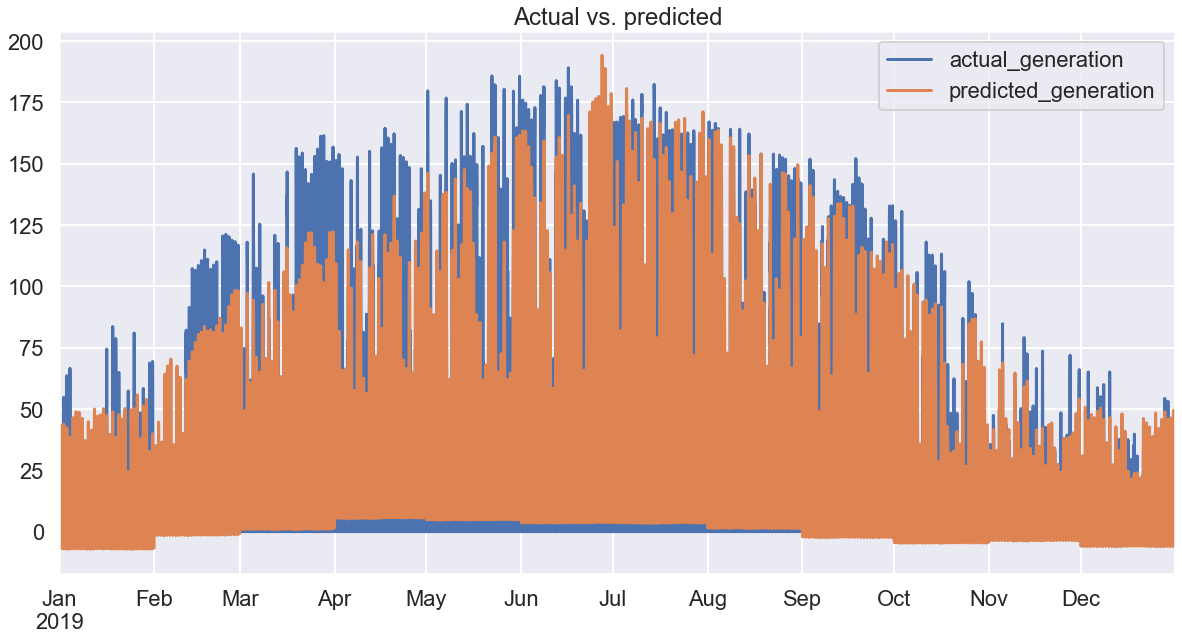

In [119]:
sns.set("poster")
fig, ax = plt.subplots(figsize=(20,10))
df_predict_actual.plot(ax=ax).set_xlabel("")
plt.legend(df_predict_actual.columns)
plt.title("Actual vs. predicted")
plt.show()

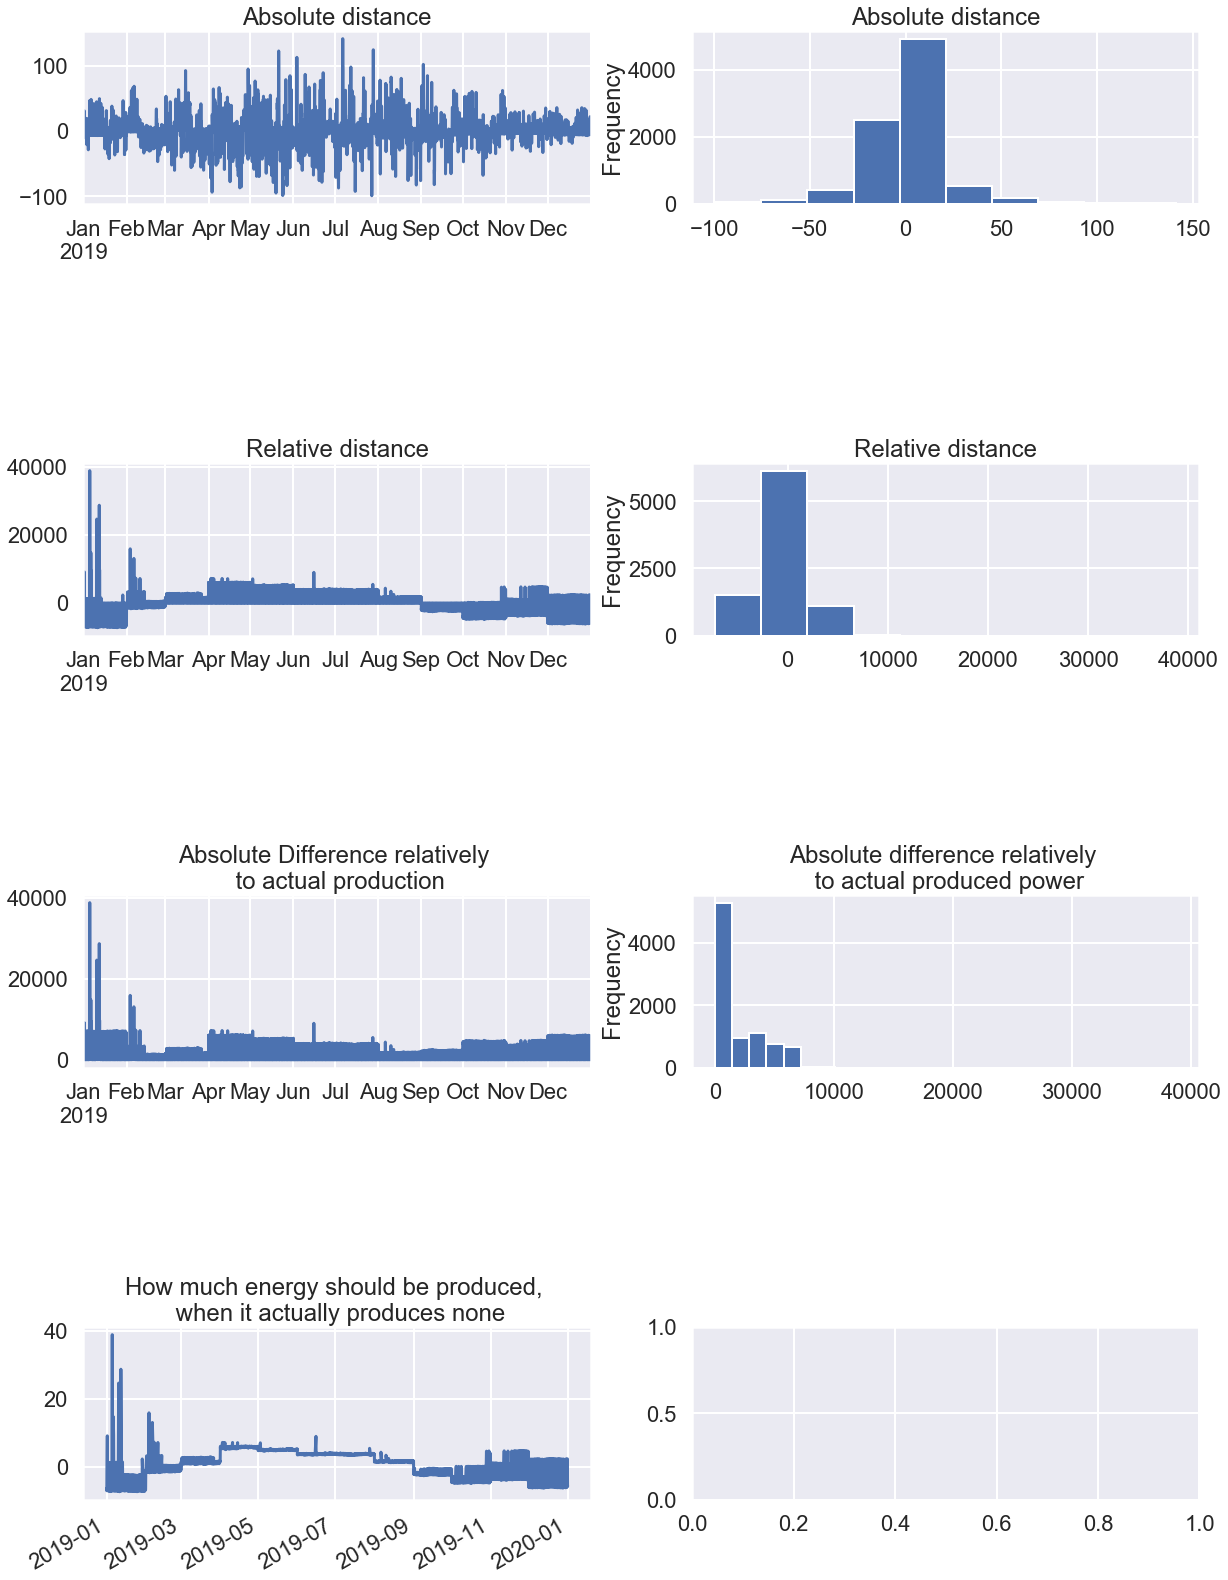

In [120]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,30))
plt.subplots_adjust(hspace=1.5)

prediction = df_predict_actual["predicted_generation"]
target = df_predict_actual["actual_generation"]

absolute_distance = prediction - target
relative_distance = prediction / (target+0.001)
absolute_difference = (prediction - target).abs()
relative_difference = absolute_difference / (target+0.001)
absolute_difference_relative_to_target = absolute_difference/(target+0.001)

# absolute distance plots
absolute_distance.plot(title="Absolute distance", ax=axes[0][0]).set_xlabel("")
absolute_distance.plot(title="Absolute distance", kind="hist", ax=axes[0][1])

# relative_distance plots
relative_distance.plot(title="Relative distance", ax=axes[1][0]).set_xlabel("")
relative_distance.plot(title="Relative distance", kind="hist", ax=axes[1][1])

# absolute_difference
relative_difference.plot(title="Absolute Difference relatively \n to actual production",
                                            ax=axes[2][0]).set_xlabel("")
relative_difference.plot(title="Absolute difference relatively \n to actual produced power", 
                         kind="hist", bins=27, ax=axes[2][1])

# edge cases
prediction_if_no_production = prediction.loc[target == 0]
production_if_no_prediction = target.loc[prediction == 0]

prediction_if_no_production.plot(title="How much energy should be produced, \n when it actually produces none",
                                ax=axes[3][0]).set_xlabel("")

# production_if_no_prediction.plot(title="How much energy is produced, \n when it actualy is predicted to be none",
#                                 ax=axes[3][1]).set_xlabel("")
plt.show()

### Classification

In [121]:
df_predict_actual.head()

,actual_generation,predicted_generation
timestamp_utc,,
2019-01-01 00:00:00+00:00,0.0,-6.294834
2019-01-01 01:00:00+00:00,0.0,-6.619468
2019-01-01 02:00:00+00:00,0.0,-6.262345
2019-01-01 03:00:00+00:00,0.0,-6.284889
2019-01-01 04:00:00+00:00,0.0,-6.919283


In [132]:
#df_predict_actual.drop('label_machine_working', axis=1, inplace=True)
min_threshold = 0.1 * df_predict_actual["predicted_generation"]
df_predict_actual['label_machine_working'] = df_predict_actual["actual_generation"] > min_threshold
df_predict_actual['label_machine_working'].fillna(value=True, inplace=True)

In [133]:
df_predict_actual.head()

,actual_generation,predicted_generation,label_machine_working,cumulative_consecutive_count_for_machine_working_label
timestamp_utc,,,,
2019-01-01 00:00:00+00:00,0.0,-6.294834,True,0
2019-01-01 01:00:00+00:00,0.0,-6.619468,True,1
2019-01-01 02:00:00+00:00,0.0,-6.262345,True,2
2019-01-01 03:00:00+00:00,0.0,-6.284889,True,3
2019-01-01 04:00:00+00:00,0.0,-6.919283,True,4


In [134]:
print("True values: ", len(df_predict_actual.loc[df_predict_actual['label_machine_working'] == True]))
print("False values: ", len(df_predict_actual.loc[df_predict_actual['label_machine_working'] == False]))
print("Ratio: ", len(df_predict_actual.loc[df_predict_actual['label_machine_working'] == False]) / len(df_predict_actual))

True values:  6594
False values:  2165
Ratio:  0.24717433496974542


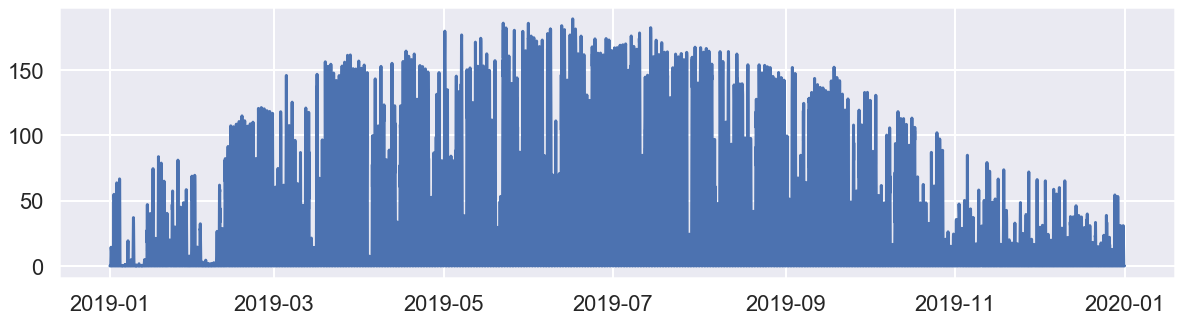

In [138]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_predict_actual["actual_generation"]
    , label=df_predict_actual["label_machine_working"]
)

In [139]:
# only regard a certain number of consecutive failures as "real" failures

consecutive_failure_threshold = 12

df_predict_actual["cumulative_consecutive_count_for_machine_working_label"] = (df_predict_actual.groupby(
    (df_predict_actual['label_machine_working'] != df_predict_actual['label_machine_working'].shift()).cumsum())
                                    .cumcount())

# show "real" failures
df_predict_actual.query('label_machine_working == False & cumulative_consecutive_count_for_machine_working_label > @consecutive_failure_threshold')

,actual_generation,predicted_generation,label_machine_working,cumulative_consecutive_count_for_machine_working_label
timestamp_utc,,,,
2019-03-02 06:00:00+00:00,0.232,8.759046,False,13
2019-03-07 06:00:00+00:00,0.172,4.940994,False,13
2019-03-15 06:00:00+00:00,0.464,16.437927,False,13
2019-04-04 23:00:00+00:00,0.000,5.808833,False,13
2019-04-05 00:00:00+00:00,0.000,5.822119,False,14
2019-04-05 01:00:00+00:00,0.000,5.446320,False,15
2019-04-05 02:00:00+00:00,0.000,5.776536,False,16
2019-04-05 03:00:00+00:00,0.000,5.747636,False,17
2019-04-05 04:00:00+00:00,0.000,5.105644,False,18


## Further Research
- Multiple Linear Regression may not be a suitable model
    - Model does not fit well during the night
    - Problem of Collinearity
    - Log-Transformation
- Alternatives: Nonlinear models, ML, Random Forest, ANN, Time Series Analysis
- Discussion: Time Series Analysis vs. Multivariate Approaches
